# Next Word Predictor/ Smart Compose
Using book data (pdf format), needed to be convert into text first, that dataset gonna used as input data to perfrom text preprocessing, text representation, embedding, etc

Mainly steps:
1. Extract Text
2. Cleaning Code
3. Tokenization
4. Create Input–Output Sequences

In [3]:
pip install PyPDF2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 8.7 MB/s eta 0:00:00


In [5]:
import PyPDF2
pdf_files = ["book1.pdf", "book2.pdf", "book3.pdf"]

all_text = ""

for pdf in pdf_files:
    print(f"Extracting text from {pdf} ...")
    with open(pdf, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        for page in reader.pages:
            text = page.extract_text()
            if text:
                all_text += text + "\n"

# Save extracted text
with open("dataset.txt", "w", encoding="utf-8") as f:
    f.write(all_text)

print("✅ Extraction complete. Saved as dataset.txt")

Extracting text from book1.pdf ...
Extracting text from book2.pdf ...
Extracting text from book3.pdf ...
✅ Extraction complete. Saved as dataset.txt


In [7]:
from google.colab import files
files.download("dataset.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
!ls


book1.pdf  book2.pdf  book3.pdf  dataset.txt  sample_data


In [14]:
with open("dataset.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(text[50000:50500])   # first 1000 characters


niques that underlie classiﬁcation, prediction, association, and clus-
tering. These topics are presented with examples, a tour of the best algorithms for each
problem class, and with pragmatic rules of thumb about when to apply each technique.
The Socratic presentation style is both very readable and very informative. I certainly
learned a lot from reading the ﬁrst edition and got re-educated and updated in reading
the second edition.
Jiawei Han and Micheline Kamber have been leading contributo


# Total Words Count and Most Common Words Listing

In [15]:
words = text.split()
print("Total words:", len(words))


Total words: 759464


In [23]:
from collections import Counter

counter = Counter(words)
print(counter.most_common(20))


[('the', 36159), ('of', 21378), ('and', 18184), ('a', 15357), ('to', 13693), ('in', 13325), ('is', 11034), ('for', 7659), ('that', 6749), ('data', 6316), ('are', 6005), ('be', 5595), ('as', 5124), ('The', 4514), ('can', 4097), ('on', 3900), ('by', 3595), ('an', 3308), ('or', 3249), ('we', 3150)]


# Cleaning Code

In [19]:
import re

# Load text
with open("dataset.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Cleaning
text = text.lower()
text = re.sub(r'\n+', ' ', text)
text = re.sub(r'[^a-z ]', ' ', text)
text = re.sub(r'\s+', ' ', text)

print("Cleaned sample:")
print(text[250000:250500])


Cleaned sample:
o states are equally important the attribute is symmetric otherwise it is asymmetric anordinal attribute is an attribute with possible values that have a meaningful order or ranking among them but the magnitude between successive values is not known anumeric attribute isquantitative i e it is a measurable quantity represented in integer or real values numeric attribute types can be interval scaled orratio scaled the values of an interval scaled attribute are measured in xed and equal units ratio


In [20]:
# Tokenizer with vocab limit

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=20000)  # LIMIT vocab
tokenizer.fit_on_texts([text])

word_index = tokenizer.word_index
print("Total unique words (raw):", len(word_index))


Total unique words (raw): 29109


In [24]:
SEQ_LEN = 30   # 30 words input → 1 word output

In [25]:
token_list = tokenizer.texts_to_sequences([text])[0]
print("Total tokens:", len(token_list))

Total tokens: 741242


In [26]:
import numpy as np

X = []
y = []

for i in range(SEQ_LEN, len(token_list)):
    X.append(token_list[i-SEQ_LEN:i])
    y.append(token_list[i])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (741212, 30)
y shape: (741212,)


# Padding — DO WE NEED IT?
NO padding needed
Because:
- All sequences are already length = 30
-  Padding is only needed when sequences have variable length

# Build the LSTM Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input

model = Sequential([
    Input(shape=(SEQ_LEN,)),          # <-- THIS FIXES EVERYTHING
    Embedding(input_dim=20000, output_dim=100),
    LSTM(128),
    Dropout(0.2),
    Dense(20000, activation='softmax')
])


In [29]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 30, 100)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20000)          │     2,580,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,697,248 (17.92 MB)

 Trainable params: 4,697,248 (17.92 MB)

 Non-trainable params: 0 (0.00 B)

# Split data

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42
)

print(X_train.shape, X_val.shape)


(667090, 30) (74122, 30)


Add callbacks
- Prevents overfitting + saves best model.

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(
        'next_word_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [34]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=256,
    callbacks=callbacks
)


Epoch 1/15
2605/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0661 - loss: 7.0947

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 56s 19ms/step - accuracy: 0.0661 - loss: 7.0945 - val_accuracy: 0.0920 - val_loss: 6.5479
Epoch 2/15
2604/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0962 - loss: 6.4679

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.0962 - loss: 6.4679 - val_accuracy: 0.1099 - val_loss: 6.3026
Epoch 3/15
2605/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1149 - loss: 6.1599

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.1149 - loss: 6.1599 - val_accuracy: 0.1272 - val_loss: 6.1151
Epoch 4/15
2603/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1316 - loss: 5.9112

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.1317 - loss: 5.9112 - val_accuracy: 0.1429 - val_loss: 5.8924
Epoch 5/15
2603/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1459 - loss: 5.6778

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.1459 - loss: 5.6777 - val_accuracy: 0.1570 - val_loss: 5.7091
Epoch 6/15
2604/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1605 - loss: 5.4470

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.1605 - loss: 5.4470 - val_accuracy: 0.1716 - val_loss: 5.5476
Epoch 7/15
2605/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1765 - loss: 5.2352

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.1765 - loss: 5.2352 - val_accuracy: 0.1799 - val_loss: 5.4538
Epoch 8/15
2604/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1861 - loss: 5.0878

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.1861 - loss: 5.0878 - val_accuracy: 0.1857 - val_loss: 5.4352
Epoch 9/15
2606/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1877 - loss: 5.1016

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.1877 - loss: 5.1016 - val_accuracy: 0.1908 - val_loss: 5.3625
Epoch 10/15
2604/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1988 - loss: 4.8991

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.1988 - loss: 4.8991 - val_accuracy: 0.1963 - val_loss: 5.3088
Epoch 11/15
2604/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2066 - loss: 4.7794

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.2066 - loss: 4.7794 - val_accuracy: 0.2002 - val_loss: 5.2942
Epoch 12/15
2606/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2139 - loss: 4.6865

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.2139 - loss: 4.6865 - val_accuracy: 0.2073 - val_loss: 5.2266
Epoch 13/15
2605/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2222 - loss: 4.5793

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.2222 - loss: 4.5793 - val_accuracy: 0.2122 - val_loss: 5.1979
Epoch 14/15
2603/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2286 - loss: 4.4836

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.2286 - loss: 4.4837 - val_accuracy: 0.2159 - val_loss: 5.1772
Epoch 15/15
2604/2606 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2371 - loss: 4.3907

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.2371 - loss: 4.3908 - val_accuracy: 0.2185 - val_loss: 5.1770


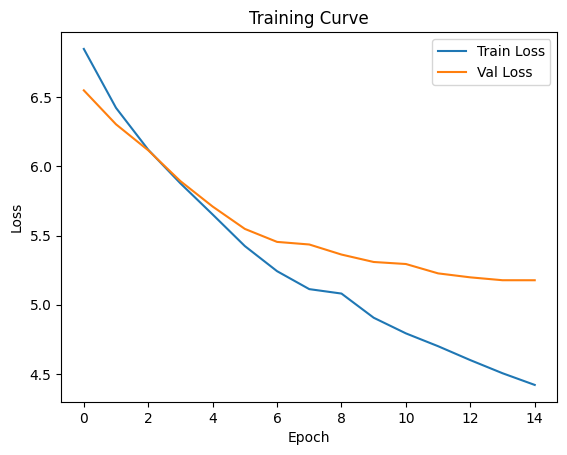

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.show()


# DEMO TIME

In [41]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_next_word_sampling(model, tokenizer, text, seq_len=30, temperature=1.0, top_k=10):
    tokens = tokenizer.texts_to_sequences([text])[0]
    tokens = tokens[-seq_len:]
    padded = pad_sequences([tokens], maxlen=seq_len, padding='pre')

    preds = model.predict(padded, verbose=0)[0]

    preds = np.log(preds + 1e-9) / temperature
    probs = np.exp(preds) / np.sum(np.exp(preds))

    top_indices = np.argsort(probs)[-top_k:]
    top_probs = probs[top_indices]
    top_probs /= np.sum(top_probs)

    return tokenizer.index_word[np.random.choice(top_indices, p=top_probs)]


In [55]:
print(predict_next_word_sampling(model, tokenizer, "once upon a", temperature=0.8))
print(predict_next_word_sampling(model, tokenizer, "once upon a", temperature=1.8))


table
database


In [61]:
print(predict_next_word_sampling(
    model, tokenizer,
    "once upon a time there was a",
    temperature=2.9
))


time


In [89]:
tests = [
    "index is the table is",
    "how to mine patterns that carry rich",
    "the meaning of training",
    "Data entries can be associated with"
]

for t in tests:
    print(t, "→", predict_next_word_sampling(model, tokenizer, t, temperature=4.3))


index is the table is → used
how to mine patterns that carry rich → new
the meaning of training → tuples
Data entries can be associated with → an


In [ ]:
# HOW TO FIX AND IMPROVE MORE

In [ ]:
bad_words = [
    "table", "database", "figure", "chapter",
    "index", "isbn", "copyright"
]

clean_lines = []
for line in text.split("."):
    if not any(word in line for word in bad_words):
        clean_lines.append(line)

text = ". ".join(clean_lines)


# Multi-word / Sentence Generation

In [69]:
def generate_text(model, tokenizer, seed_text, n_words=20, temperature=1.0):
    result = seed_text

    for _ in range(n_words):
        next_word = predict_next_word_sampling(
            model, tokenizer, result,
            temperature=temperature
        )
        result += " " + next_word

    return result


In [80]:
print(generate_text(model, tokenizer, "once upon a table", 20, temperature=2.9))
print(generate_text(model, tokenizer, "This book is:", 15))

# The output is like this becaues a Database book is used to train the model,
# if used more better books to train, then good results.


once upon a table of the schema that includes all of the data type of data type by the same as its corresponding and
This book is: an overview of a dbms for this book a dbms is an important system in


In [79]:
for temp in [2.9, 3.8, 1.2]:
    print(f"Temp {temp}:",
          generate_text(model, tokenizer, "Table is used", 10, temp))


Temp 2.9: Table is used in database and write sql queries see the database for
Temp 3.8: Table is used using dynamic hashing the cost components is an ordered structure
Temp 1.2: Table is used to create a set of employees in figure a query


In [91]:
files.download("next_word_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("tokenizer.pkl saved")


✅ tokenizer.pkl saved


In [93]:
from google.colab import files
files.download("tokenizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>